## The imapact of the batch_sizeand randomiztion on grid-wise statistics

For grid-wise statistics, we need to use batch-based approach to fit data into the memory. Though the pooled statistics is well-established, we want to verify the results is acceptable.

In earlier attemps, we found that larger batch always showed larger standard deviations, and suspect that is due to that fact we calculate each batch in time series orderly. Hence, we do some randomization before batching.

In [1]:
import numpy as np
import pandas as pd
import os, argparse, logging

# Utility functions
def list_himawari8_files(dir, suffix='.btp', to_remove='.B13.PCCU.btp'):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    xfiles = []
    for root, dirs, files in os.walk(dir): 
        for fn in files:
            if fn.endswith(suffix): 
                 xfiles.append({'timestamp':fn.replace(to_remove,''), 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_himawari8_btp(furi):
    ''' The method reads in a Himawari 8 image in binary format (.btp file). 
        the binary file contains 10,890,000 float point numbers (4-byte) represent 
        the brightness temperature. '''
    data = np.fromfile(furi, np.float32)
    return(data.reshape((3300,3300)))

def read_multiple_himawari8(flist, test_flag=False):
    data = []
    for f in flist:
        if test_flag:
            data.append(read_himawari8_btp(f)[1600:1700,1600:1700])
        else:
            data.append(read_himawari8_btp(f))
    return(np.array(data))

# Statistical summary
# Per-grid analysis
def summarize_by_grid(data):
    ''' Given a 3D numpy array, calculate the mean and variance on the first axis. '''
    mean_image = np.mean(data, axis=0)
    var_image = np.var(data, axis=0)
    return({'mean':mean_image, 'variance':var_image})

def summarize_himawari8_by_grid(flist, batch_size=None):
    ''' Calculate grid-by-grid statistics of a list of Himawari-8 images. '''
    if batch_size is None:  # Read in all data
        data = read_multiple_himawari8(flist)
        summary = summarize_images_by_grid(data)
    else:                   # Read in data by batch
        # Shuffle flist for random batching
        if shuffle:
            flist = flist.sample(frac=1, random_state=rseed).reset_index(drop=True)
            logging.debug('Shuffling the input data for batch processing.')
        pooled_mean = None
        pooled_var = None
        nSample = len(flist)
        batch_start = 0
        batch_end = batch_size
        batch_count = 0
        # Loop through all files
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            logging.debug("Batch "+str(batch_count)+', size:'+str(limit-batch_start))
            data = read_multiple_himawari8(flist[batch_start:limit])#, test_flag=True)
            # calculate statistics by increment
            tmp = summarize_by_grid(data)
            if pooled_mean is None:
                pooled_mean = (limit - batch_start)*tmp['mean']
                pooled_var = (limit - batch_start - 1)*tmp['variance']
            else:
                pooled_mean += (limit - batch_start)*tmp['mean']
                pooled_var += (limit - batch_start - 1)*tmp['variance']
            # increment
            batch_start += batch_size   
            batch_end += batch_size
            batch_count += 1
        # Pooling
        pooled_mean = pooled_mean/nSample
        pooled_var = pooled_var/(nSample-batch_count)
        summary={'mean':pooled_mean, 'variance':pooled_var}
    # 
    return(summary)

## Test range

We used all currently available Himawari8 images, 2017-03-01 ~ 2017-08-31 with batch size 128 and 256.

In [2]:
logging.basicConfig(level=logging.INFO)
b128m = read_himawari8_btp('b128_mean.btp')
b256m = read_himawari8_btp('b256_mean.btp')
b128v = read_himawari8_btp('b128_std.btp')
b256v = read_himawari8_btp('b256_std.btp')

In [4]:
print('Mean')
print('b128-b256:')
print(np.percentile(np.abs(b128m-b256m),[0,25,50,75,100]))

print('Stadard Deviation')
print('b128-b256:')
print(np.percentile(np.abs(b128v-b256v),[0,25,50,75,100]))

print('b256:'+str(np.mean(b256v)))
print('b128:'+str(np.mean(b128v)))

Mean
b128-b256:
[0.00000000e+00 3.05175781e-05 6.10351562e-05 9.15527344e-05
 3.35693359e-04]
Stadard Deviation
b128-b256:
[0.6062355  1.5290184  1.79829121 2.02753353 3.24342728]
b256:15.696727
b128:13.898144


## Quick intepretations

The mean values are not influenced by batch-processing, but the stdev values are. The average of stdev is around $10^2$ where the difference between different batch-size is as large as 25%.

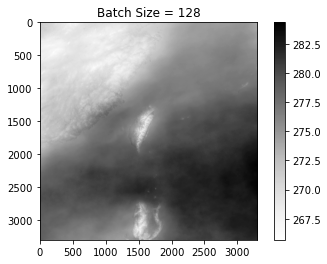

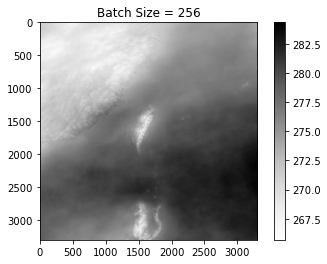

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(b128m, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 128')
plt.colorbar()
plt.show()

plt.imshow(b256m, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 256')
plt.colorbar()
plt.show()

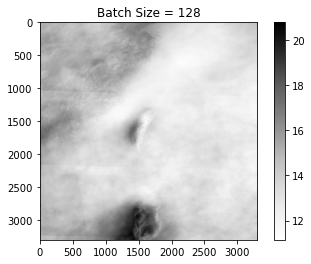

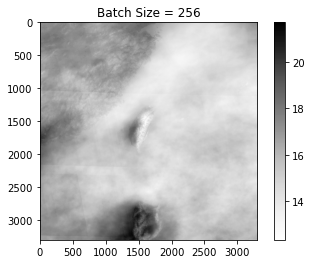

In [6]:
plt.imshow(b128v, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 128')
plt.colorbar()
plt.show()

plt.imshow(b256v, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 256')
plt.colorbar()
plt.show()

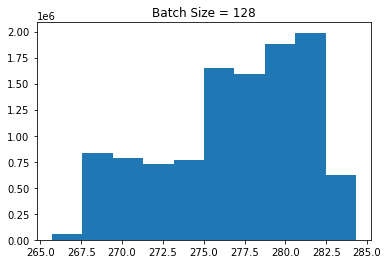

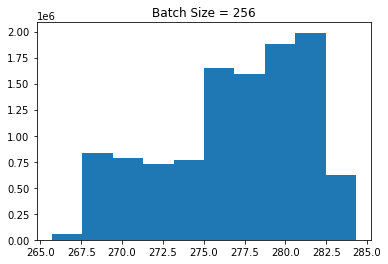

In [7]:
plt.hist(b128m.flatten())
plt.title('Batch Size = 128')
plt.show()
plt.hist(b256m.flatten())
plt.title('Batch Size = 256')
plt.show()

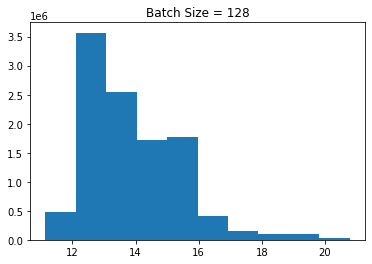

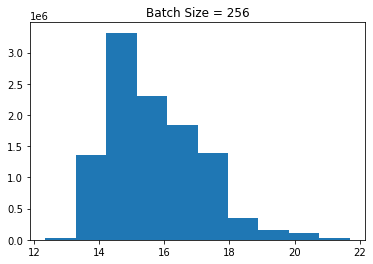

In [8]:
plt.hist(b128v.flatten())
plt.title('Batch Size = 128')
plt.show()
plt.hist(b256v.flatten())
plt.title('Batch Size = 256')
plt.show()

### Test for randomization

The batch-size showed cecrtain impact on the stdev of grid-wise statistics, and hence we added randomization before batch-processing.

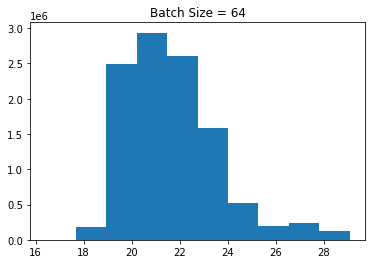

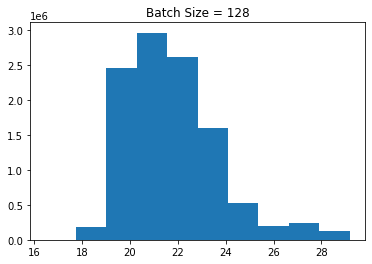

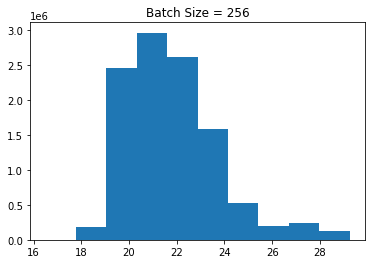

In [9]:
b128av = read_himawari8_btp('b128_r1_std.btp')
b128bv = read_himawari8_btp('b128_r2_std.btp')
b128cv = read_himawari8_btp('b128_r3_std.btp')
b256v = read_himawari8_btp('b256_r1_std.btp')
b64v = read_himawari8_btp('b64_r1_std.btp')

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(b64v.flatten())
plt.title('Batch Size = 64')
plt.show()
plt.hist(b128av.flatten())
plt.title('Batch Size = 128')
plt.show()
plt.hist(b256v.flatten())
plt.title('Batch Size = 256')
plt.show()

### Randomization works!

After some randomization, the batch-processing stdev seems more stable. The difference between different baatch-size is much smaller (from $10^2$ down to $10^{-2}$, and the histograms looked very similar. However, a larger batch-size is still recommended.



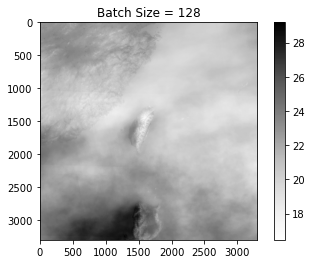

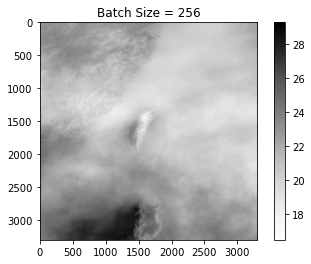

In [10]:
plt.imshow(b128av, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 128')
plt.colorbar()
plt.show()

plt.imshow(b256v, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 256')
plt.colorbar()
plt.show()

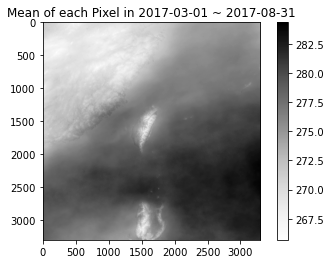

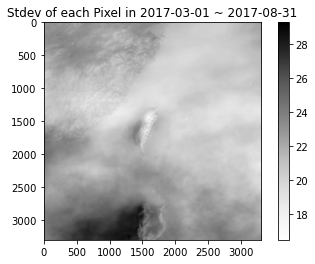

In [13]:
b256rm = read_himawari8_btp('b256_r1_mean.btp')
b256rv = read_himawari8_btp('b256_r1_std.btp')

plt.imshow(b256rm, alpha=0.99, cmap='Greys')
plt.title('Mean of each Pixel in 2017-03-01 ~ 2017-08-31')
plt.colorbar()
plt.show()

plt.imshow(b256rv, alpha=0.99, cmap='Greys')
plt.title('Stdev of each Pixel in 2017-03-01 ~ 2017-08-31')
plt.colorbar()
plt.show()